# Property regression example

## low level interface

To show how the components of NFFLr work together, let's train a formation energy model using the `dft_3d` dataset.
We can use the `periodic_radius_graph` transform to configure the `AtomsDataset` to automatically transform atomic configurations into `DGLGraph`s.

In [1]:
import nfflr

transform = nfflr.nn.PeriodicRadiusGraph(cutoff=5.0)

dataset = nfflr.AtomsDataset(
    "dft_3d", 
    target="formation_energy_peratom", 
    transform=transform,
)
dataset[0]

dataset_name='dft_3d'
Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


(Graph(num_nodes=8, num_edges=288,
       ndata_schemes={'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor(-0.4276))

`AtomsDataset` can also load structures from the directory format that ALIGNN uses; the directory should contain a collection of POSCAR, CIF, or XYZ files and a mapping from file names to prediction targets in the file `id_prop.csv`.

For example, loading the small set of POSCAR files distributed with `nfflr` (and `alignn`):

In [10]:
import inspect
from pathlib import Path

nfflr_root = Path(inspect.getfile(nfflr)).parent

dataset = nfflr.AtomsDataset(
    nfflr_root / "examples/sample_data", 
    target="target", 
    transform=transform,
)
dataset[0]

dataset_name=PosixPath('/Users/bld/projects/nfflr/nfflr/examples/sample_data')


(Graph(num_nodes=8, num_edges=392,
       ndata_schemes={'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor(0.))

Set up a medium-sized ALIGNN model:

In [11]:
cfg = nfflr.models.ALIGNNConfig(
    transform=transform,
    alignn_layers=2, 
    gcn_layers=2, 
    norm="layernorm", 
    atom_features="embedding"
)
model = nfflr.models.ALIGNN(cfg)

atoms, target = dataset[0]
model(atoms)

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


tensor(0.3195, grad_fn=<SqueezeBackward0>)

`AtomsDataset` is meant to work nicely with standard pytorch DataLoaders.
Because of the rich structure of the common input formats for atomistic ML, often a custom [collation function](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) is needed to properly auto-batch samples - `AtomsDataset` tries to automatically select an appropriate `collate_fn` for tasks that it knows about, which can be accessed by `AtomsDataset.collate`.

In [12]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler

batchsize = 2

train_loader = DataLoader(
    dataset,
    batch_size=batchsize, 
    collate_fn=dataset.collate, 
    sampler=SubsetRandomSampler(dataset.split["train"]),
    drop_last=True
)
next(iter(train_loader))

(Graph(num_nodes=8, num_edges=80,
       ndata_schemes={'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor([1.6810, 0.0000]))

Now we can set up a PyTorch optimizer and objective function and optimize the model parameters with an explicit training loop. See the [PyTorch quickstart tutorial for more context)[https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html].

In [13]:
from tqdm import tqdm
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.1)

training_loss = []
for epoch in range(5):
    for step, (g, y) in enumerate(tqdm(train_loader)):
        pred = model(g)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        training_loss.append(loss.item())

100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


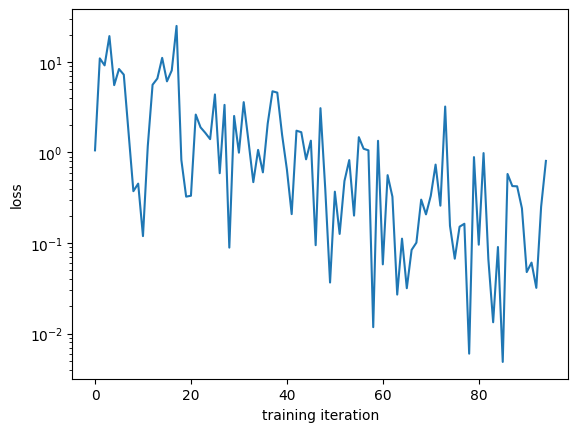

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(training_loss)
plt.xlabel("training iteration")
plt.ylabel("loss");
plt.semilogy();

# using the ignite-based NFFLr trainer

In [15]:
import tempfile
from nfflr import train

In [16]:
rank = 0
training_config = {
    "dataset": dataset,
    "model": model,
    "optimizer": optimizer,
    "criterion": criterion,
    "random_seed": 42,
    "batch_size": 2,
    "learning_rate": 1e-3,
    "weight_decay": 0.1,
    "epochs": 5,
    "num_workers": 0,
    "progress": True,
    "output_dir": tempfile.TemporaryDirectory().name
}
train.run_train(rank, training_config)

2024-01-24 14:46:26,979 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<nfflr.data.dataset.': 
	{'collate_fn': <function AtomsDataset.collate_default at 0x29a06a560>, 'batch_size': 2, 'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x107b71510>, 'drop_last': True, 'num_workers': 0, 'pin_memory': False}
2024-01-24 14:46:26,979 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<nfflr.data.dataset.': 
	{'collate_fn': <function AtomsDataset.collate_default at 0x29a06a560>, 'batch_size': 2, 'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x30ec1da80>, 'drop_last': True, 'num_workers': 0, 'pin_memory': False}
/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using st

starting training loop


[1/19]   5%|5          [00:00<?]

[1/1] 100%|########## [00:00<?]

train results - Epoch: 1  Avg loss: 0.01


[1/2]  50%|#####      [00:00<?]

val results - Epoch: 1  Avg loss: 3.60


[1/19]   5%|5          [00:00<?]

[1/1] 100%|########## [00:00<?]

train results - Epoch: 2  Avg loss: 0.45


[1/2]  50%|#####      [00:00<?]

val results - Epoch: 2  Avg loss: 4.95


[1/19]   5%|5          [00:00<?]

[1/1] 100%|########## [00:00<?]

train results - Epoch: 3  Avg loss: 0.05


[1/2]  50%|#####      [00:00<?]

val results - Epoch: 3  Avg loss: 1.20


[1/19]   5%|5          [00:00<?]

[1/1] 100%|########## [00:00<?]

train results - Epoch: 4  Avg loss: 0.02


[1/2]  50%|#####      [00:00<?]

val results - Epoch: 4  Avg loss: 3.59


[1/19]   5%|5          [00:00<?]

[1/1] 100%|########## [00:00<?]

train results - Epoch: 5  Avg loss: 0.00


[1/2]  50%|#####      [00:00<?]

val results - Epoch: 5  Avg loss: 3.85


3.854463577270508